### features:
* time domain features
* statistical features
* selected spectogram coef
* all zero crossing rate coef
* all chromogram values
* no tempogram values
* no wavelet
* fractal analysis


In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

In [2]:
path =  "/Users/ecem/Desktop/phonocardiogram/data"

## Load data

In [3]:
time_domain_features = pd.read_csv(path + "/time-domain-features.csv", index_col = 0)
statistical_features = pd.read_csv(path + "/statistical-features.csv", index_col = 0)
fractal_features = pd.read_csv(path + "/mock-features.csv", index_col = 0)
bandpower = pd.read_csv(path + "/bandpower.csv", index_col = 0)

In [4]:
features = pd.concat([statistical_features, time_domain_features, fractal_features, bandpower], axis = 1)
features.head()

,mean,std,skewness,kurtosis,harmonic mean,ac peak height mean,energy,entropy,spectral entropy,spectral rolloff,...,higuchi f.a.,deterended fluctuations f.a.,peak max,peak min,19'th bandpower,23'th bandpower,24'th bandpower,25'th bandpower,26'th bandpower,27'th bandpower
0,-0.000040,0.060224,-0.638895,51.817342,4.405790e-10,2.167401,0.003627,1.669286,0.188441,0.07420,...,1.091685,0.921825,0.032980,0.010268,0.000261,6.109667e-12,6.990118e-13,1.567410e-13,3.271238e-14,7.560295e-15
1,-0.000483,0.027385,0.169739,2.901926,1.058298e-08,0.825860,0.000750,2.963927,0.043663,0.04800,...,1.052431,0.904970,0.023604,0.010027,0.000012,1.665456e-12,2.279566e-13,5.451163e-14,1.162113e-14,2.702502e-15
2,-0.000067,0.019704,0.181507,4.582113,2.210099e-09,0.303073,0.000388,2.840991,0.017348,0.04395,...,1.046259,0.982775,0.023554,0.010067,0.000003,5.443871e-13,9.449346e-14,2.406857e-14,5.290868e-15,1.248620e-15
3,-0.000062,0.022971,-0.092871,3.136028,4.928371e-09,0.467023,0.000528,2.859511,0.025138,0.04730,...,1.048935,0.942318,0.020444,0.010010,0.000006,1.157595e-12,1.613553e-13,4.033335e-14,8.847740e-15,2.087383e-15
4,0.000141,0.026843,0.031420,4.079496,1.251589e-11,0.599395,0.000721,2.733358,0.029182,0.04545,...,1.046809,0.918872,0.027402,0.010116,0.000003,1.824674e-12,2.502706e-13,6.282048e-14,1.378203e-14,3.249271e-15


## Load labels

In [5]:
labels = np.load(path + "/labels.npy", allow_pickle = True)

## PCA:
* AIM: Reducing the dimensionality of data while preserving as much as possible of the information contained in the original data
* Uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.
* 

In [6]:
from sklearn.decomposition import PCA

In [7]:
features.mean()

mean                            6.614615e-06
std                             5.639694e-02
skewness                        3.006978e-01
kurtosis                        2.958815e+01
harmonic mean                   1.268917e-08
ac peak height mean             6.498616e+00
energy                          6.272990e-03
entropy                         2.683098e+00
spectral entropy                1.055324e-01
spectral rolloff                4.327951e-02
spectral centorid               4.334294e-02
petrosian f.a.                  1.002794e+00
katz f.a.                       1.943058e+00
higuchi f.a.                    1.082730e+00
deterended fluctuations f.a.    1.060059e+00
peak max                        2.851053e-02
peak min                        1.021563e-02
19'th bandpower                 1.751305e-04
23'th bandpower                 2.087087e-11
24'th bandpower                 2.101077e-12
25'th bandpower                 4.724636e-13
26'th bandpower                 9.959302e-14
27'th band

In [8]:
data = features - features.mean()
data = data / data.std()

In [9]:
data

,mean,std,skewness,kurtosis,harmonic mean,ac peak height mean,energy,entropy,spectral entropy,spectral rolloff,...,higuchi f.a.,deterended fluctuations f.a.,peak max,peak min,19'th bandpower,23'th bandpower,24'th bandpower,25'th bandpower,26'th bandpower,27'th bandpower
0,-0.057914,0.068819,-0.729406,0.450930,-0.207681,-0.230043,-0.166101,-2.141526,0.509288,1.137373,...,0.221159,-0.865729,0.382438,0.112511,0.113438,-0.156108,-0.238684,-0.263599,-0.270010,-0.271818
1,-0.605796,-0.521716,-0.101663,-0.541343,-0.035711,-0.301296,-0.346683,0.593209,-0.380049,0.173638,...,-0.748335,-0.971290,-0.419835,-0.404173,-0.216883,-0.203108,-0.318875,-0.348951,-0.355159,-0.356509
2,-0.091383,-0.659839,-0.092528,-0.507260,-0.177678,-0.329063,-0.369401,0.333526,-0.541700,0.024663,...,-0.900791,-0.484015,-0.424065,-0.318410,-0.228836,-0.214964,-0.341596,-0.374368,-0.380716,-0.381856
3,-0.085122,-0.601094,-0.305527,-0.536594,-0.131588,-0.320355,-0.360650,0.372646,-0.493848,0.147889,...,-0.834697,-0.737386,-0.690215,-0.441119,-0.224420,-0.208479,-0.330213,-0.360789,-0.366356,-0.367233
4,0.165650,-0.531453,-0.209040,-0.517455,-0.214939,-0.313324,-0.348539,0.106166,-0.469004,0.079839,...,-0.887187,-0.884223,-0.094884,-0.213858,-0.228051,-0.201424,-0.315076,-0.342014,-0.346435,-0.346977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,-0.430060,2.982123,-0.050297,-0.533401,0.181652,4.670268,2.706340,0.485698,-0.627042,-1.134026,...,-1.636402,1.367607,-0.589856,-0.445334,-0.220139,0.184903,1.273402,1.871536,2.138863,2.249179
1201,-0.753083,2.430531,-0.215175,-0.508003,4.178247,3.368207,1.909626,0.565028,-0.621732,-1.126669,...,-1.494054,1.402465,-1.050394,-0.201913,-0.215995,0.145304,1.108509,1.651138,1.896857,1.999974
1202,0.565659,2.844954,-0.120851,-0.518782,2.545283,5.011108,2.497182,0.709297,-0.619671,-1.189202,...,-1.499495,1.543355,-0.675831,0.479465,-0.223116,0.275564,1.644863,2.391344,2.722798,2.859741
1203,-0.440797,2.411822,-0.217063,-0.524992,6.473990,3.426236,1.884659,0.654781,-0.556418,-1.145061,...,-0.685146,1.334716,-1.090833,-0.180644,-0.192261,0.165264,1.063616,1.560690,1.784078,1.874644


In [10]:
pca = PCA()
pca.fit(features)


PCA()

In [11]:
print(pca.explained_variance_ratio_)


[8.74824461e-01 1.24552058e-01 5.34275446e-04 6.02860068e-05
 2.01015829e-05 5.54534465e-06 2.70540775e-06 3.03546311e-07
 1.72918154e-07 3.67665313e-08 2.77488829e-08 2.10166899e-08
 5.00561211e-09 2.25927554e-10 1.16943014e-10 6.78610646e-11
 1.45429055e-11 1.00995149e-18 7.72189131e-25 2.61430011e-28
 1.12495024e-30 1.13550139e-33 1.94553506e-36]


In [12]:
print(sum(pca.explained_variance_ratio_))

1.0000000000000002


In [13]:
transformed = pca.transform(features)

In [14]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(transformed, labels, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [15]:
import xgboost as xgb
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf = Pipeline([('classify', classifier)])


In [16]:
clf.fit(X_train_, y_train_)


Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

In [17]:
yhat = clf.predict(X_valid_)

In [18]:
df_results_test = pd.DataFrame({'AV': y_valid_[:,0], 'MV': y_valid_[:,1], 'PV': y_valid_[:,2], 'TV': y_valid_[:,3],
                        'predicted AV': yhat[:,0],
                          'predicted MV': yhat[:,1],
                          'predicted PV': yhat[:,2], 
                          'predicted TV': yhat[:,3]})
df_results_test

,AV,MV,PV,TV,predicted AV,predicted MV,predicted PV,predicted TV
0,0.0,0.0,0.0,1.0,0,0,1,0
1,0.0,0.0,1.0,0.0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,0,0,0
3,0.0,0.0,1.0,0.0,0,0,0,0
4,0.0,1.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...
941,1.0,0.0,0.0,0.0,0,0,0,0
942,0.0,0.0,1.0,0.0,0,0,1,0
943,0.0,1.0,0.0,0.0,0,1,0,1
944,1.0,0.0,0.0,0.0,1,0,0,0


In [19]:
auc_y1 = roc_auc_score(y_valid_[:,0],yhat[:,0])
auc_y2 = roc_auc_score(y_valid_[:,1],yhat[:,1])
auc_y3 = roc_auc_score(y_valid_[:,2],yhat[:,2])
auc_y4 = roc_auc_score(y_valid_[:,3],yhat[:,3])

print("ROC AUC AV: %.4f, MV: %.4f, PV: %.4f, TV: %.4f " % (auc_y1, auc_y2, auc_y3, auc_y4))


ROC AUC AV: 0.6604, MV: 0.6202, PV: 0.6659, TV: 0.6584 


In [20]:
weighted_roc_auc_ovo = roc_auc_score(
    y_valid_, yhat, multi_class="ovr", average="weighted"
)

In [21]:
weighted_roc_auc_ovo

0.6523536224695574

In [22]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


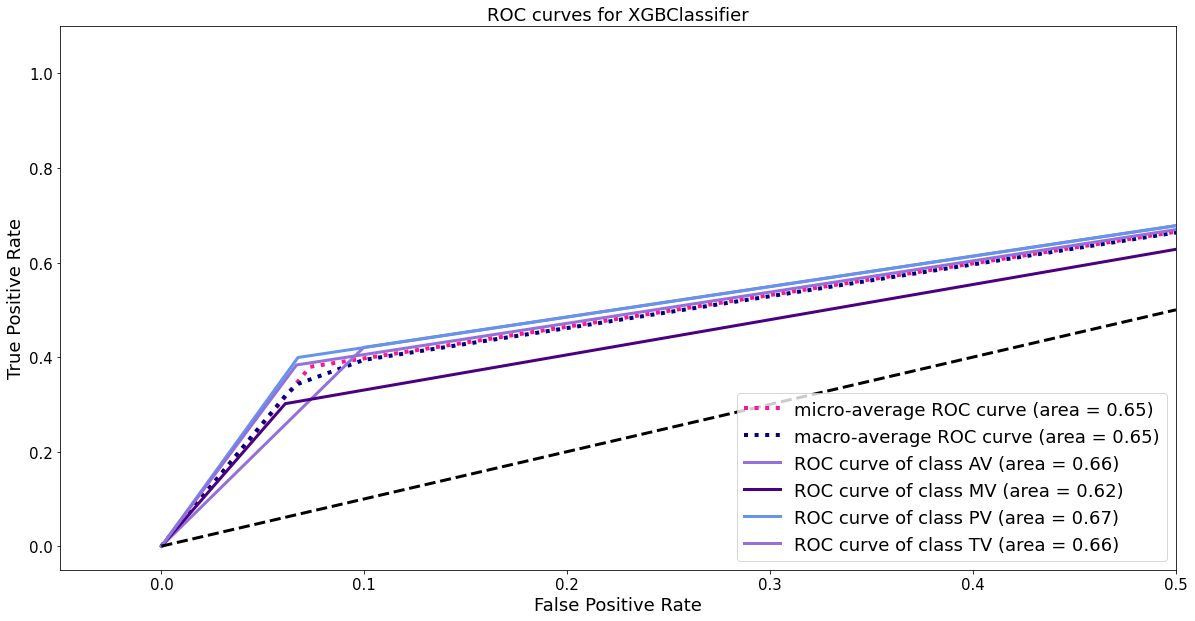

In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AV", "MV", "PV", "TV"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate",fontsize = 18 )
plt.ylabel("True Positive Rate", fontsize = 18)
plt.title("ROC curves for XGBClassifier",fontsize = 18)
plt.legend(loc="lower right", fontsize = 18) 
plt.show()

In [24]:
cm_y1 = confusion_matrix(y_valid_[:,0],yhat[:,0])
cm_y2 = confusion_matrix(y_valid_[:,1],yhat[:,1])
cm_y3 = confusion_matrix(y_valid_[:,2],yhat[:,2])
cm_y4 = confusion_matrix(y_valid_[:,3],yhat[:,3])
print(cm_y1)



[[614  68]
 [153 111]]


In [25]:
class_dict = {0:'AV', 1:'MV', 2:'PV', 3:'TV'}

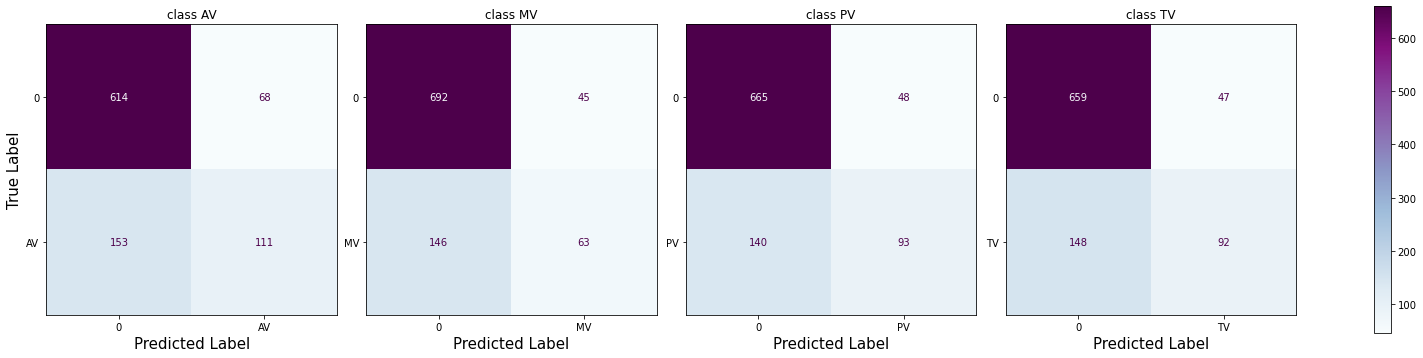

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(1, 4, figsize=(28, 15))
axes = axes.ravel()
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_valid_[:, i],
                                                   yhat[:, i]),
                                  display_labels=[0, i])
    if i == 0:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel('True Label', fontsize = 15)
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
    else:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel(' ')
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
        

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink= 0.4)
plt.show()

In [27]:
cm_y2

array([[692,  45],
       [146,  63]])

In [28]:
cm_y3

array([[665,  48],
       [140,  93]])

In [29]:
cm_y4

array([[659,  47],
       [148,  92]])

In [30]:
cr_y1 = classification_report(y_valid_[:,0],yhat[:,0]) # AR
cr_y2 = classification_report(y_valid_[:,1],yhat[:,1]) # AS
cr_y3 = classification_report(y_valid_[:,2],yhat[:,2]) # MR
cr_y4 = classification_report(y_valid_[:,3],yhat[:,3]) # MS

print (cr_y1)
print (cr_y2)
print (cr_y3)
print (cr_y4)




              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       682
         1.0       0.62      0.42      0.50       264

    accuracy                           0.77       946
   macro avg       0.71      0.66      0.67       946
weighted avg       0.75      0.77      0.75       946

              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88       737
         1.0       0.58      0.30      0.40       209

    accuracy                           0.80       946
   macro avg       0.70      0.62      0.64       946
weighted avg       0.77      0.80      0.77       946

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       713
         1.0       0.66      0.40      0.50       233

    accuracy                           0.80       946
   macro avg       0.74      0.67      0.69       946
weighted avg       0.79      0.80      0.78       946

              preci